#Movie Recommendation Project

###Loading Dataset

In [ ]:
pip install kagglehub


In [ ]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1


In [ ]:
import pandas as pd

# Load the datasets
movies = pd.read_csv('/content/movie.csv.zip')


# Display the first few rows of each dataset
print("Movies Dataset:")
print(movies.head())

print("\nRatings Dataset:")



Movies Dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Dataset:


In [ ]:
import zipfile

# Extract files from ZIP
with zipfile.ZipFile('/content/rating.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Load the extracted files

ratings = pd.read_csv('/content/rating.csv.zip')


In [ ]:
print("\nRatings Dataset:")
print(ratings.head())


Ratings Dataset:
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40


###Data Processing

In [ ]:
# Check for missing values
print("\nMissing Values in Movies:")
print(movies.isnull().sum())

print("\nMissing Values in Ratings:")
print(ratings.isnull().sum())

# Quick statistics for ratings
print("\nRatings Statistics:")
print(ratings['rating'].describe())



Missing Values in Movies:
movieId    0
title      0
genres     0
dtype: int64

Missing Values in Ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Ratings Statistics:
count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [ ]:
# Extract release year from the title
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False)

# Split genres into a list
movies['genres'] = movies['genres'].str.split('|')

# Preview the modified movies dataset
print("\nModified Movies Dataset:")
print(movies.head())



Modified Movies Dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                              genres  year  
0  [Adventure, Animation, Children, Comedy, Fantasy]  1995  
1                     [Adventure, Children, Fantasy]  1995  
2                                  [Comedy, Romance]  1995  
3                           [Comedy, Drama, Romance]  1995  
4                                           [Comedy]  1995  


###Exploring the data

In [ ]:
# Count ratings per movie
ratings_per_movie = ratings['movieId'].value_counts()
top_rated_movies = ratings_per_movie.head(10)

# Merge with movies dataset for movie titles
top_rated_movies = pd.DataFrame(top_rated_movies).reset_index()
top_rated_movies.columns = ['movieId', 'count']
top_rated_movies = top_rated_movies.merge(movies, on='movieId')

print("\nMost Rated Movies:")
print(top_rated_movies[['title', 'count']])

# Average ratings per movie
average_ratings = ratings.groupby('movieId')['rating'].mean()
top_avg_rated_movies = average_ratings.sort_values(ascending=False).head(10)

print("\nHighest Average Rated Movies:")
print(top_avg_rated_movies)



Most Rated Movies:
                                       title  count
0                        Pulp Fiction (1994)  67310
1                        Forrest Gump (1994)  66172
2           Shawshank Redemption, The (1994)  63366
3           Silence of the Lambs, The (1991)  63299
4                       Jurassic Park (1993)  59715
5  Star Wars: Episode IV - A New Hope (1977)  54502
6                          Braveheart (1995)  53769
7          Terminator 2: Judgment Day (1991)  52244
8                         Matrix, The (1999)  51334
9                    Schindler's List (1993)  50054

Highest Average Rated Movies:
movieId
95517     5.0
105846    5.0
89133     5.0
105187    5.0
105191    5.0
88488     5.0
126945    5.0
105526    5.0
105529    5.0
105841    5.0
Name: rating, dtype: float64


###Model

In [ ]:
movies = movies[['movieId', 'title', 'genres']]
ratings = ratings[['userId', 'movieId', 'rating']]


In [ ]:
print(movies.isnull().sum())
print(ratings.isnull().sum())

# Drop rows with missing values (if any)
movies.dropna(inplace=True)
ratings.dropna(inplace=True)


movieId    0
title      0
genres     0
dtype: int64
userId     0
movieId    0
rating     0
dtype: int64


In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])


In [ ]:
# Filter movies with less than 10 ratings
popular_movies = ratings.groupby('movieId').filter(lambda x: len(x) >= 10)

# Filter users with less than 10 interactions
active_users = popular_movies.groupby('userId').filter(lambda x: len(x) >= 10)


In [ ]:
from scipy.sparse import csr_matrix

# Create a sparse matrix
user_item_matrix = csr_matrix((ratings['rating'], (ratings['userId'], ratings['movieId'])))


In [ ]:
# Filter movies with less than 10 ratings
filtered_ratings = ratings.groupby('movieId').filter(lambda x: len(x) >= 10)

# Filter users with less than 10 interactions
filtered_ratings = filtered_ratings.groupby('userId').filter(lambda x: len(x) >= 10)


In [ ]:
# Randomly sample 10,000 users and their ratings
sampled_ratings = ratings[ratings['userId'].isin(ratings['userId'].sample(10000))]

# Create the matrix again
user_item_matrix = sampled_ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)


In [ ]:
# Downcast numerical columns
ratings['userId'] = ratings['userId'].astype('int32')
ratings['movieId'] = ratings['movieId'].astype('int32')
ratings['rating'] = ratings['rating'].astype('float32')


In [ ]:
!pip install scikit-surprise


In [ ]:
# Reduce dataset size (optional)
small_ratings = ratings.sample(frac=0.1, random_state=42)  # Use 10% of the data
# Filter users and movies with sufficient ratings
min_user_ratings = 10
min_movie_ratings = 10

filtered_ratings = ratings.groupby('userId').filter(lambda x: len(x) >= min_user_ratings)
filtered_ratings = filtered_ratings.groupby('movieId').filter(lambda x: len(x) >= min_movie_ratings)


###Surprise Training Model

In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

# Reduce the dataset size
small_ratings = ratings.sample(frac=0.1, random_state=42)

# Prepare data for surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(small_ratings[['userId', 'movieId', 'rating']], reader)

# Split data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train the model
algo = SVD()
algo.fit(trainset)

# Evaluate on the test set
predictions = algo.test(testset)

# Print performance metrics
from surprise.accuracy import rmse, mae
rmse(predictions)
mae(predictions)


RMSE: 0.9000
MAE:  0.6946


0.6946145745489936

In [ ]:
# Predict for a specific user and movie
user_id = 1  # Replace with a user ID from your dataset
movie_id = 1  # Replace with a movie ID from your dataset

prediction = algo.predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} on movie {movie_id}: {prediction.est:.2f}")


Predicted rating for user 1 on movie 1: 3.64


In [ ]:
from collections import defaultdict

def get_top_n_recommendations(predictions, n=10):
    # Map the predictions to each user
    top_n = defaultdict(list)
    for pred in predictions:
        top_n[pred.uid].append((pred.iid, pred.est))

    # Sort the predictions for each user and retrieve the top N
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Get top 10 recommendations for all users
top_n = get_top_n_recommendations(predictions, n=10)

# Print recommendations for the first user
user_id = list(top_n.keys())[0]
print(f"Top 10 recommendations for user {user_id}: {top_n[user_id]}")


Top 10 recommendations for user 121787: [(260, 4.403318699872758), (1210, 3.4926633355990973), (6502, 3.3359933738200023), (6281, 3.2707355853784965), (2, 3.2247448549758406), (2353, 3.1962108464993193), (4036, 3.0452508491767376), (8360, 2.9929472418525918), (1801, 2.756216158698211), (3825, 2.2041754762607986)]


###Accuracy

In [ ]:
from surprise import accuracy

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_hits = defaultdict(int)
    user_total = defaultdict(int)

    for uid, _, true_r, est, _ in predictions:
        user_total[uid] += 1
        if est >= threshold and true_r >= threshold:
            user_hits[uid] += 1

    precision = sum(user_hits.values()) / sum(user_total.values())
    return precision

precision = precision_recall_at_k(predictions, k=10, threshold=3.5)
print(f"Precision@10: {precision:.2f}")


Precision@10: 0.43


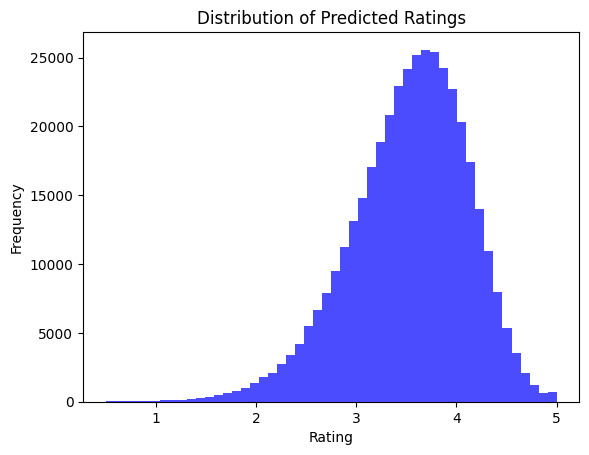

In [ ]:
import matplotlib.pyplot as plt

# Extract predicted ratings
predicted_ratings = [pred.est for pred in predictions]

# Plot histogram
plt.hist(predicted_ratings, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()
